In [39]:
import pandas as pd
import numpy as np

url = "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data"

# Load the SAheart dataset
df = pd.read_csv(url, index_col='row.names')

# Convert binary text data to numbered categories
df['famhist'] = pd.Categorical(df['famhist']).codes

# Extract the name of the attributes (columns)
attributeNames = list(map(lambda x: x.capitalize(), df.columns.tolist()))

# Convert the dataframe to numpy
y = df['chd'].to_numpy() # classification problem of CHD or no CHD
X = df.drop(columns=['chd']).to_numpy() # rest of the attributes, remove 'CHD' column

# Compute size of X
N, M = X.shape # N = observations, M = attributes (except 'chd')
N_numbers = np.arange(1, N+1)

# Normalize the datapoints to have a mean of 0 
mu = np.mean(X, 0)
sigma = np.std(X, 0)

X = (X - mu) / sigma


Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10


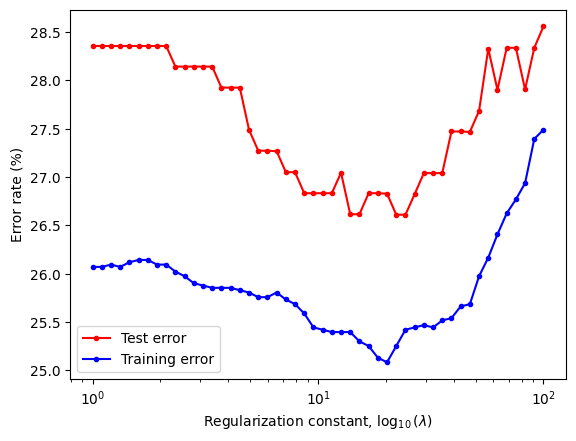

The best lambdas = [10^0, 10^2]
1
100


In [40]:
# Find the best regularization value for logistic regression.ipynb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import matplotlib.pyplot as plt

lambda_reg =  np.logspace(0, 2, 50)

# Using K-fold 10 cross validation
K_fold = 10
CV = model_selection.KFold(K_fold, shuffle = False)

train_error = np.zeros((K_fold, len(lambda_reg)))
test_error = np.zeros((K_fold, len(lambda_reg)))
coefficient_norm = np.zeros((K_fold, len(lambda_reg)))

i = 0  # Reset i to 0 at the start of the outer loop
for train_index, test_index in CV.split(X, y):
    print("Crossvalidation fold: {0}/{1}".format(i + 1, 10))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]

    for l in range(len(lambda_reg)):
        # print("Regularization constant: {0}".format(lambda_reg[l]))

        # train model
        model_logreg = LogisticRegression(penalty="l2", C=1/lambda_reg[l], max_iter=500)
        model_logreg.fit(X_train, y_train)

        # predict test and training data
        y_est_test = model_logreg.predict(X_test)
        y_est_train = model_logreg.predict(X_train)

        error_rate_test = 100 * np.sum(y_est_test != y_test)/len(y_test)
        error_rate_train = 100 * np.sum(y_est_train != y_train)/len(y_train)

        w_est = model_logreg.coef_[0]
        coeff_norm = np.sqrt(np.sum(w_est**2))

        test_error[i,l] = error_rate_test
        train_error[i,l] = error_rate_train
        coefficient_norm[i,l] = coeff_norm

    i += 1

# Plot the classification error rate
plt.figure()
plt.semilogx(lambda_reg, np.mean(test_error, axis=0), 'r.-', label='Test error')
plt.semilogx(lambda_reg, np.mean(train_error, axis=0), 'b.-', label='Training error')
plt.legend()
plt.xlabel('Regularization constant, $\log_{10}(\lambda)$')
plt.ylabel("Error rate (%)")
plt.show()

print("The best lambdas = [10^0, 10^2]")
print(10**0)
print(10**2)




Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10


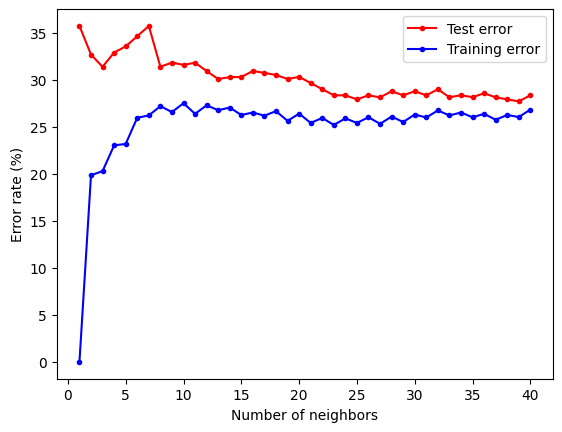

The optimal k-nearest neigbor is k = [1, 25]


In [41]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

# Find the optimal number of neighbors

# Maximum number of neighbors
L = np.arange(1,40+1)

CV = model_selection.KFold(10)
test_error = np.zeros((10,len(L)))
train_error = np.zeros((10,len(L)))
i = 0

for train_index, test_index in CV.split(X, y):
    print("Crossvalidation fold: {0}/{1}".format(i + 1, 10))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]

    # Fit classifier and classify the test points for each neighbors
    for idx,l in enumerate(L): 
        #metric='mahalanobis'
        #metric_params={'V': np.cov(X_train, rowvar=False)}
        metric = "minkowski"
        metric_params = {}  
        knclassifier = KNeighborsClassifier(n_neighbors=l, p = 2, metric = metric, metric_params = metric_params) # choose the model
        knclassifier.fit(X_train, y_train) # fits the model to X_train, y_train

        # predict test and training data
        y_est_test = knclassifier.predict(X_test) # estimate y from X_test
        y_est_train = knclassifier.predict(X_train) # estimate y from X_train

        # find error
        error_rate_test = np.sum(y_est_test != y_test)/len(y_test)
        error_rate_train = np.sum(y_est_train != y_train)/len(y_train)

        test_error[i,idx] = error_rate_test
        train_error[i,idx] = error_rate_train
        

    i += 1

# Plot the classification error rate
plt.figure()
plt.plot(L, 100*np.mean(test_error, axis=0), 'r.-', label='Test error')
plt.plot(L, 100*np.mean(train_error, axis=0), 'b.-', label='Training error')
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Error rate (%)")
plt.show()

print('The optimal k-nearest neigbor is k = [1, 25]')


In [42]:
# Two-layer cross validation

# K-fold for cross validation
k = 0 # index of CV
Kfold = 10 # maximum CV
CV = model_selection.KFold(Kfold) # model for CV

# for evaluation of logistic regression
lambdas = np.logspace(-2, 3, 50)
chosen_lambdas = np.zeros(Kfold)

# estimations of w's for the chosen lambda
w_est_ALL = np.zeros(Kfold)

# for evaluation of KNN
ks = np.arange(1,30+1)
chosen_ks = np.zeros(Kfold)

# arrays to save the predicted values
y_true = []
y_est_KNN_All = []
y_est_LOGREG_All = []
y_est_base_All = []

# miss classification
Missclass_KNN = np.zeros(Kfold)
Missclass_LOGREG = np.zeros(Kfold)
Missclass_base = np.zeros(Kfold)

# Outer fold
for train_index_out, test_index_out in CV.split(X,y):
    print("# Outer fold: {0}/{1}".format(k + 1, Kfold))
    
    # Extract the training and test set for the outer-fold
    X_train_out = X[train_index_out, :]
    y_train_out = y[train_index_out]
    X_test_out = X[test_index_out, :]
    y_test_out = y[test_index_out]

    # Inner fold for chosing the right k and lambda
    i = 0

    # to save the errors for the different lambda- and ks-values
    test_error_lambdas = np.zeros(len(lambdas))
    test_error_ks = np.zeros(len(ks))

    for train_index, test_index in CV.split(X_train_out,y_train_out):
        
        # Extract training and test set for current inner fold
        X_train = X_train_out[train_index, :]
        y_train = y_train_out[train_index]
        X_test = X_train_out[test_index, :]
        y_test = y_train_out[test_index]

        # find optimal lambda value for the training set
        for idx, lambdas_values in enumerate(lambdas):
            # train model
            model_logreg = LogisticRegression(penalty="l2", C=1/lambdas_values, max_iter=500)
            model_logreg.fit(X_train, y_train)

            # predict test and training data
            y_est_test_logreg = model_logreg.predict(X_test)

            # find error of predictions
            test_error_lambdas[idx]= np.sum(y_est_test_logreg != y_test)/len(y_test)

        
        # find optimal k-value for KNN
        for idx, ks_values in enumerate(ks): 
            metric = "minkowski"
            metric_params = {}  
            knclassifier = KNeighborsClassifier(n_neighbors=int(ks_values), p = 2, metric = metric, metric_params = metric_params) # choose the model
            knclassifier.fit(X_train, y_train) # fits the model to X_train, y_train

            # predict test and training data
            y_est_test_KNN = knclassifier.predict(X_test) # estimate y from X_test

            # find error
            test_error_ks[idx] = np.sum(y_est_test_KNN != y_test)/len(y_test)

        i += 1
        
    min_value_lambdas = np.min(test_error_lambdas) # find lowest test error
    min_index_lambdas = np.where(test_error_lambdas == min_value_lambdas)[0] # the indices of min_error
    # lambda value for logistic regression
    chosen_lambdas[k] = lambdas[min_index_lambdas[0]]

    min_value_ks = np.min(test_error_ks) # find lowest test error
    min_index_ks = np.where(test_error_ks == min_value_ks)[0] # the indices of min_error
    # k-value for nearest neighbor, use the largest number. 
    chosen_ks[k] = ks[min_index_ks[0]]

    ### Train the outer-set with the chosen k and lambda ###
    ## The true y-values
    y_true.append(y_test_out)

    ## K-nearest neigbors 
    knclassifier = KNeighborsClassifier(n_neighbors=int(chosen_ks[k]), p = 2, metric = metric, metric_params = metric_params)
    knclassifier.fit(X_train_out, y_train_out)
    # test
    y_est_KNN = knclassifier.predict(X_test_out)
    y_est_KNN_All.append(y_est_KNN)
    Missclass_KNN[k] = 100 * (np.sum(y_est_KNN != y_test_out)/len(y_test_out))
    
    ## Logistic Regression
    logisticclassifier = LogisticRegression(C = 1/chosen_lambdas[k], max_iter = 500)
    logisticclassifier.fit(X_train_out, y_train_out) 
    # test
    y_est_LOGREG = logisticclassifier.predict(X_test_out)
    y_est_LOGREG_All.append(y_est_LOGREG)
    Missclass_LOGREG[k] = 100 * (np.sum(y_est_LOGREG != y_test_out)/len(y_test_out))
    
    ## Baseline
    a = 0
    b = 0
    while True:
        for c in range(len(y_train)):
            if y_train_out[c] == 0:  # No CHD class
                a += 1
            elif y_train_out[c] == 1:  # CHD class
                b += 1
        
        # test
        if a > b: # If the class of no CHD (a) is largest
            y_est_base = np.full(len(y_test_out), 0) # baseline predicts all y's to not have CHD
            y_est_base_All.append(y_est_base)
            break
        else: # If the class of CHD (b) is largest
            y_est_base = np.full(len(y_test_out), 1) # baseline predicts all y's to have CHD
            y_est_base_All.append(y_est_base)
            break
    Missclass_base[k] = 100 * (np.sum(y_est_base != y_test_out)/len(y_test_out)) # error of each innerfold as columns
    
    k += 1



Class_df_columns = pd.MultiIndex.from_tuples([
    ("Outer fold", "i"), 
    ("KNN", "k"),
    ("KNN", "Error_test (%)"),
    ("Logistic regression", "lambda"),
    ("Logistic regression", "Error_test(%)"),
    ("Baseline", "Error_test(%)")])

Outer_fold = np.round(np.arange(1, Kfold + 1),0)
 
Class_df_data = np.array([Outer_fold, 
                          chosen_ks, # k-value
                          Missclass_KNN, # Error_test of KNN
                          chosen_lambdas, # Lambda
                          Missclass_LOGREG, # Error_test of logistic function
                          Missclass_base]).T

Class_df = pd.DataFrame(Class_df_data, columns=Class_df_columns)
print(Class_df)


# Outer fold: 1/10
# Outer fold: 2/10
# Outer fold: 3/10
# Outer fold: 4/10
# Outer fold: 5/10
# Outer fold: 6/10
# Outer fold: 7/10
# Outer fold: 8/10
# Outer fold: 9/10
# Outer fold: 10/10
  Outer fold   KNN                Logistic regression                \
           i     k Error_test (%)              lambda Error_test(%)   
0        1.0   3.0      36.170213            0.010000     31.914894   
1        2.0   3.0      38.297872           47.148664     29.787234   
2        3.0   2.0      26.086957          152.641797     19.565217   
3        4.0   2.0      36.956522          152.641797     32.608696   
4        5.0   3.0      39.130435           95.409548     39.130435   
5        6.0  10.0      43.478261           18.420700     30.434783   
6        7.0   3.0      23.913043           18.420700     21.739130   
7        8.0   2.0      32.608696           95.409548     23.913043   
8        9.0   2.0      39.130435            0.010000     26.086957   
9       10.0  30.0      21.7

In [46]:
# Comparison of models

from dtuimldmtools import mcnemar

# Compute the Jeffreys interval
alpha = 0.05
print("\n")

# Convert lists to numpy arrays and stack them properly
y_true_array = np.hstack(y_true)
y_est_KNN_All_array = np.hstack(y_est_KNN_All)
y_est_LOGREG_array = np.hstack(y_est_LOGREG_All)
y_est_base_array = np.hstack(y_est_base_All)

[thetahat, CI, p] = mcnemar(y_true_array, y_est_KNN_All_array, y_est_LOGREG_array, alpha=alpha)
print(thetahat)


[thetahat, CI, p] = mcnemar(y_true_array, y_est_KNN_All_array, y_est_base_array, alpha=alpha)
print(thetahat)

[thetahat, CI, p] = mcnemar(y_true_array, y_est_base_array, y_est_LOGREG_array, alpha=alpha)
print(thetahat)




Result of McNemars test using alpha= 0.05
Comparison matrix n
[[278.  28.]
 [ 55. 101.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (np.float64(-0.09663526660282717), np.float64(-0.020163247939667728))
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.004039208886669413
-0.05844155844155844
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[256.  50.]
 [ 46. 110.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (np.float64(-0.03285936131821532), np.float64(0.050160654542728))
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.7596492883236297
0.008658008658008658
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[266.  36.]
 [ 67.  93.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (np.float64(-0.1096071110729252), np.float64(-0.024471483150244833))
p-value for two-sided test A and B have same accuracy (exact binomial test): 